In [1]:
# set to true if you desire to train the model again
retrain = False

# Part 1 : Training a classifier model
In this section, we aim to train a classifier model $g$ that follows the definition:\

A classifier $g:\mathbb{R}^d\rightarrow\{\mathcal{C}_i:i=1,2,\dots,c\}$ is a function such that there exists $c$ \textbf{discriminant functions} $g_i:\mathbb{R}^d\rightarrow\mathbb{R}$, $i=1,2,\dots,c$ such that for $\mathbf{x_0}\in\mathbb{R}^d$
$$
g(\mathbf{x_0}) = \mathcal{C}_{\arg\max_{i} g_i(\mathbf{x_0})}
$$
We may think of $g_i$ as the score given to class $\mathcal{C}_i$. A linear classifier refers to where all $g_i$ are linear. We follow a classifier as written in https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

In [2]:
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 32
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [4]:
# Really Simple CNN

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [5]:
import os

# Training the model
if retrain:
    net = Net().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)
    for epoch in range(10):
        epoch_loss = 0
        epoch_count = 0
        pbar = tqdm(enumerate(trainloader), total=len(trainloader))
        for i, (inputs, labels) in pbar:
            optimizer.zero_grad()
            outputs = net(inputs.to(device))
            loss = criterion(outputs, labels.to(device))
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            epoch_count += len(inputs)
            pbar.set_description(f"Training Epoch {epoch+1}: Loss = {round(epoch_loss/epoch_count,4)}")
    # Save model weights
    torch.save(net.state_dict(), "weights.pt")
else:
    if os.path.exists("weights.pt"):
        print("Weight exists, good to go")
    else:
        print("Weight file not found, you might consider retraining")

Weight exists, good to go


## Validating the trained model

In [6]:
net = Net().to(device)
net.load_state_dict(torch.load("weights.pt", map_location=device))

<All keys matched successfully>

In [7]:
# Get some x-y tuples to test on
for x_test, y_test in testloader:
    score = net(x_test.to(device)).cpu()
    probability = F.softmax(score, dim=1)
    predictions = torch.argmax(probability, dim=1)
    break
# generate target classes
y_target = (torch.tensor(np.random.choice(np.arange(1,10), len(y_test))) + y_test)%10

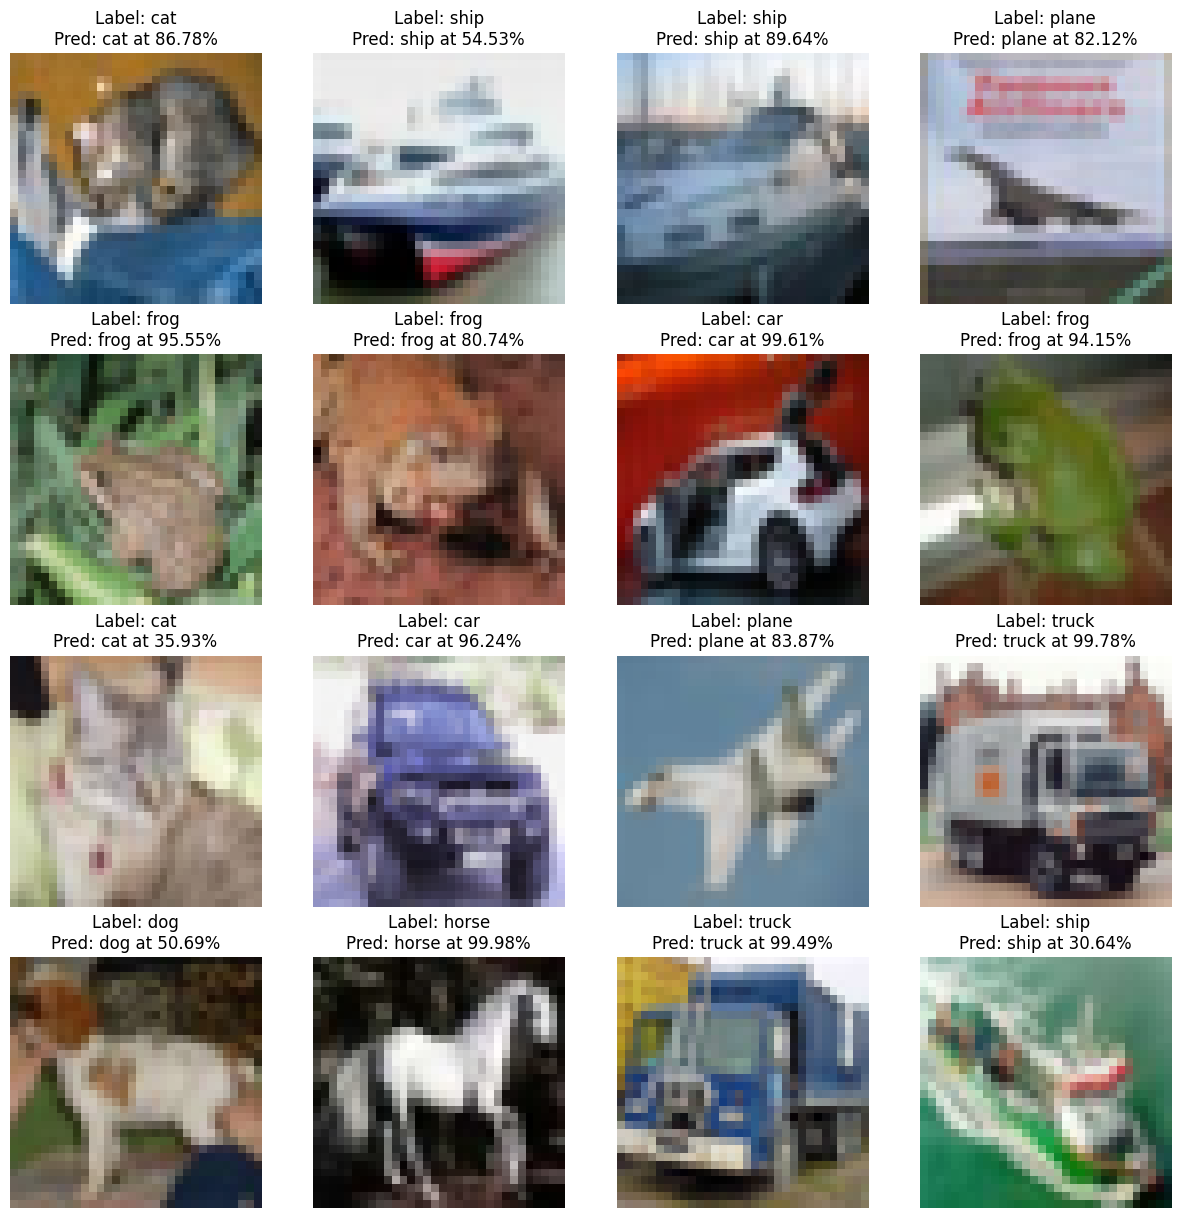

In [8]:
fig, ax = plt.subplots(4, 4, figsize=(15,15))

for i in range(4):
    for j in range(4):
        index = 4*i+j
        image = np.clip((x_test[index].permute(1,2,0).numpy()+1)/2, 0, 1)
        true = y_test[index]
        pred = predictions[index]
        prob = probability[index, pred].item()
        ax[i,j].set_title(f"Label: {classes[true]}\nPred: {classes[pred]} at {round(prob*100,2)}%")
        ax[i,j].axis('off')
        ax[i,j].imshow(image)
plt.show()

# Adversarial Attacks

A classifier $g$ is a mapping from a data point $\mathbf{x_0}$ to some (source) class $\mathcal{C}_s$. An adversarial attack on said classifier is a perturbation of $\mathbf{x_0}$ that changes to another (target) class $\mathcal{C}_t$. Formally:

## Definition of an Adversarial Attack
For some target class $\mathcal{C}_t$, an adversarial attack $\mathcal{A}:\mathbb{R}^d\rightarrow\mathbb{R}^d$ is a perturbation on data points $\mathbf{x_0}$ such that
$$
g(\mathcal{A}(\mathbf{x_0}))=\mathcal{C}_t
$$

Out of all types of adversarial attacks, we aim to focus on **additive adversarial attacks** which includes mappings $\mathcal{A}$ where $\mathcal{A}(\mathbf{x_0})=\mathbf{x_0}+\mathbf{r}$ for some $\mathbf{r}\in\mathbb{R}^d$. This additive property is appealing due to its preservation of the input space (i.e. if $\mathbf{x_0}$ is an image, then $\mathcal{A}(\mathbf{x_0})$ would still resemble an image) where a general mapping wouldn't.

# DeepFool

DeepFool computes the projection into each other class' hyperplane
$$
\mathbf{r_i} = \frac{|g_i(\mathbf{x_0})-g_s(\mathbf{x_0})|}{\|\nabla g_i(\mathbf{x_0})-\nabla g_s(\mathbf{x_0})\|_2^2}(\nabla g_i(\mathbf{x_0})-\nabla g_s(\mathbf{x_0}))
$$
and move in the direction of the least distance in a given norm.

In [9]:
net = Net().to(device)
net.load_state_dict(torch.load("weights.pt", map_location=device))

<All keys matched successfully>

## Untargeted

The deepfool defined in the original attack is untargeted:

In [10]:
def DeepFoolUntargeted(net, x, y, max_iter):
    '''
    Parameters
        net : a neural network
        x : input tensor
        y : input's original classes
        max_iter : max iteration to search for adversarial examples
    Return
        Adversarial examples
    '''
    r = torch.zeros_like(x)
    for _ in tqdm(range(max_iter)):
        x_flatten = x.reshape(-1, 3*32*32)+r.reshape(-1, 3*32*32)
        y_oh = F.one_hot(y, num_classes=10)
        
        def get_score_diff(x):
            net.zero_grad()
            predictions = net(x.reshape(-1, 3, 32, 32))
            self_score = torch.stack([predictions[i,y[i]] for i in range(len(y))]).reshape(-1,1)
            score_diff = predictions - self_score
            return score_diff
        
        score_diff = get_score_diff(x_flatten)
        grad = torch.autograd.functional.jacobian(get_score_diff, x_flatten)
        grad = torch.stack([grad[i,:,i,:] for i in range(len(grad))])
        distances = torch.abs(score_diff) / torch.sqrt((grad**2).sum(-1))
        distances = torch.nan_to_num(distances, 0) + 1e5 * y_oh # drop nan and drop own class
        best_distances = distances.argmin(-1)
        move = (torch.abs(score_diff) / (grad**2).sum(-1)).reshape(32, 10, -1) * grad
        r += torch.stack([move[i,best_distances[i]] for i in range(len(best_distances))]).reshape(-1, 3, 32, 32)
        y_pred = net(torch.clamp(x+r, -1, 1)).argmax(-1)
        
        if torch.all(y_pred==y):
            # attack successful
            break
            
    return x+r

100%|█████████████████████████████████████████████████████████████████████████████| 10/10 [00:17<00:00,  1.73s/it]


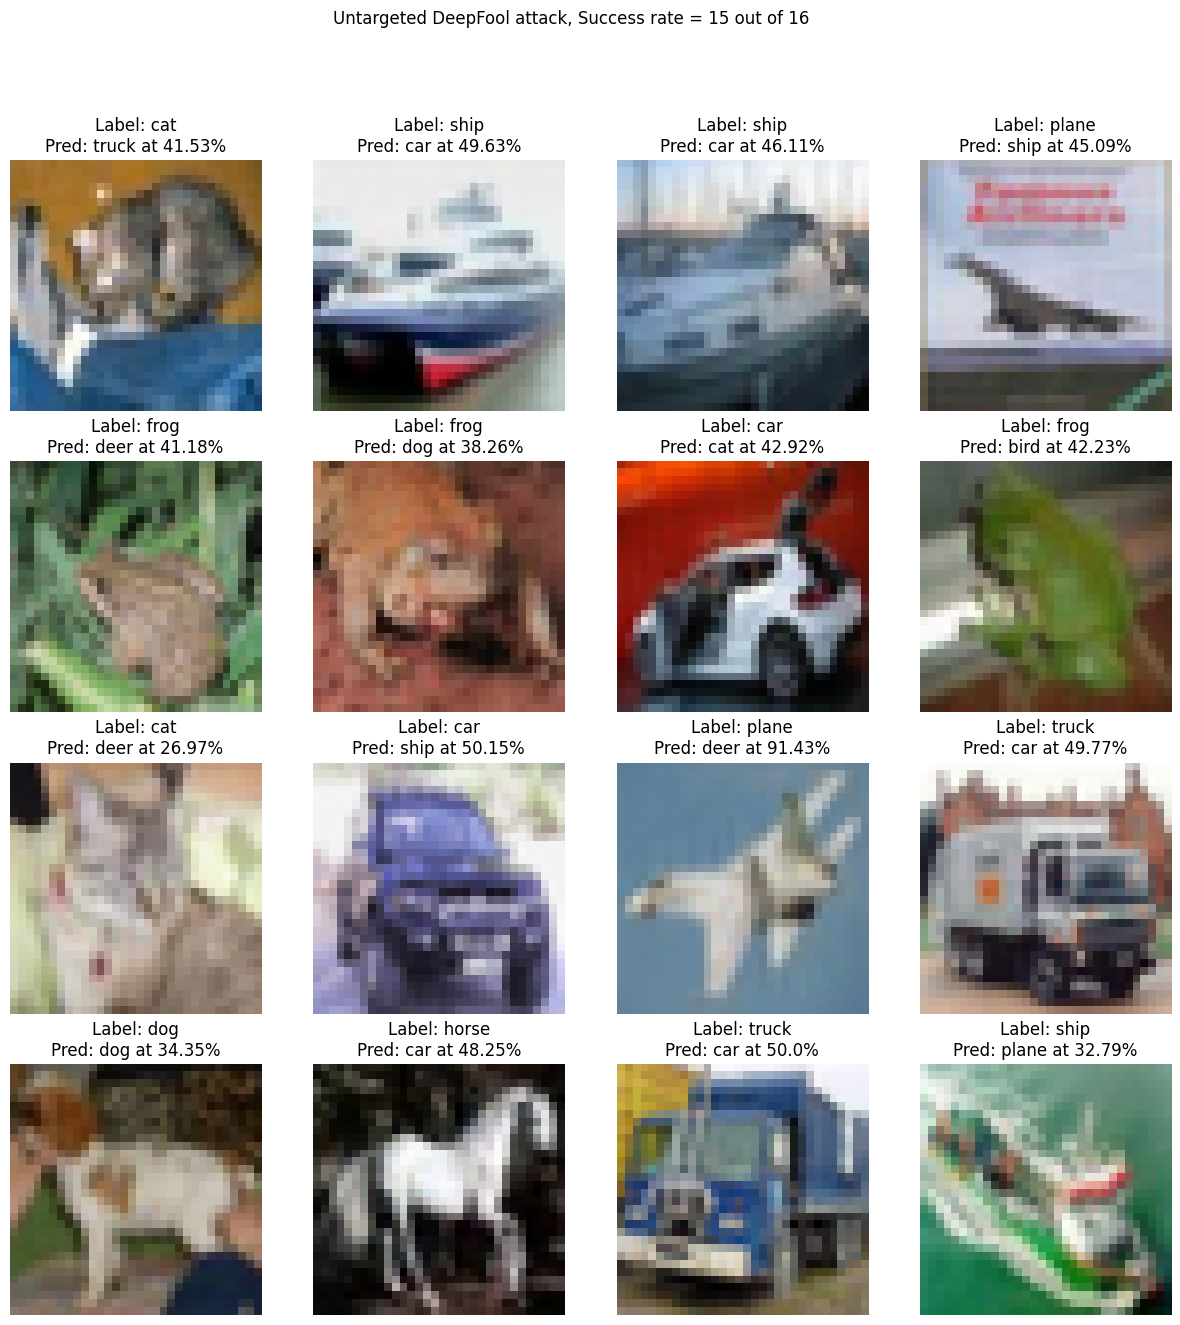

In [11]:
x_adv = DeepFoolUntargeted(net, x_test.to(device), y_test.to(device), max_iter=10).detach()
score = net(x_adv).cpu()
x_adv = x_adv.cpu()
probability = F.softmax(score, dim=1)
predictions = torch.argmax(probability, dim=1)

fig, ax = plt.subplots(4, 4, figsize=(15,15))

for i in range(4):
    for j in range(4):
        index = 4*i+j
        image = np.clip((x_adv[index].permute(1,2,0).numpy()+1)/2, 0, 1)
        true = y_test[index]
        pred = predictions[index]
        prob = probability[index, pred].item()
        ax[i,j].set_title(f"Label: {classes[true]}\nPred: {classes[pred]} at {round(prob*100,2)}%")
        ax[i,j].axis('off')
        ax[i,j].imshow(image)
    fig.suptitle(f"Untargeted DeepFool attack, Success rate = {torch.sum(predictions[0:16]!=y_test[0:16])} out of {16}")
plt.show()

# FGSM

The FGSM utilizes the sign of the gradient of the loss function to control the trajectory of generating adversarial samples under the $L_\infty$ norm. Intuitively, we want to move in the direction that **increases** the loss value (and hence creates misclassification)

In [12]:
net = Net().to(device)
net.load_state_dict(torch.load("weights.pt", map_location=device))
criterion = nn.CrossEntropyLoss()

## Untargeted

The untargeted FGSM follows:

$$
\mathbf{r}=\eta\cdot\mathrm{sign}(\nabla J_{\mathbf{x_0}}(\boldsymbol{\theta},\mathbf{x_0},\mathcal{C}_s)
$$

which follows the direction of maximum loss increase with $\eta$ to constraint the max-norm

In [13]:
def FGSM_untargeted(net, loss_fn, x, y, eps=0.05):
    '''
    Parameters
        net : a neural network
        loss_fn : loss function used to train said model
        x : input tensor
        y : input's original classes
        eps : a constraint on the change's max-norm
    Return
        Adversarial examples
    '''
    net.zero_grad()
    x.requires_grad = True
    if x.grad is not None:
        x.grad *= 0
    predictions = net(x)
    net.zero_grad()
    loss = loss_fn(predictions, y)
    loss.backward()
    r = eps*x.grad.sign()
    x = x+r
    return x.detach()

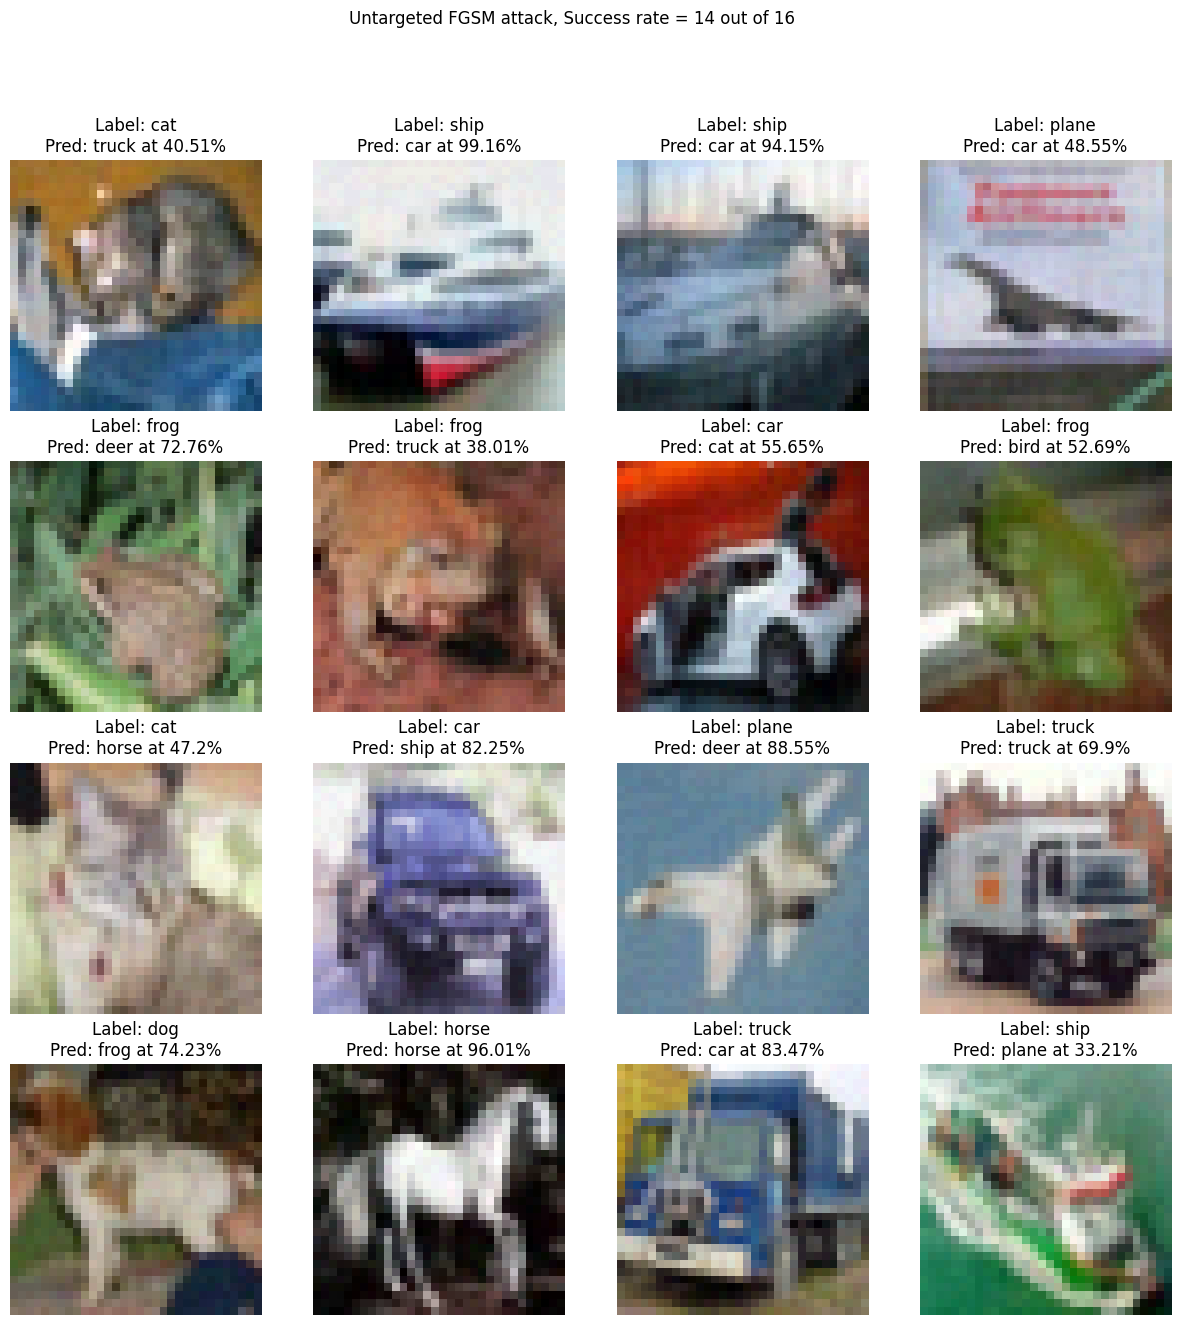

In [14]:
x_adv = FGSM_untargeted(net, criterion, x_test.to(device), y_test.to(device), eps=0.03)
score = net(x_adv).cpu()
x_adv = x_adv.cpu()
probability = F.softmax(score, dim=1)
predictions = torch.argmax(probability, dim=1)

fig, ax = plt.subplots(4, 4, figsize=(15,15))

for i in range(4):
    for j in range(4):
        index = 4*i+j
        image = np.clip((x_adv[index].permute(1,2,0).numpy()+1)/2, 0, 1)
        true = y_test[index]
        pred = predictions[index]
        prob = probability[index, pred].item()
        ax[i,j].set_title(f"Label: {classes[true]}\nPred: {classes[pred]} at {round(prob*100,2)}%")
        ax[i,j].axis('off')
        ax[i,j].imshow(image)
    fig.suptitle(f"Untargeted FGSM attack, Success rate = {torch.sum(predictions[0:16]!=y_test[0:16])} out of {16}")
plt.show()

## Targeted

The targeted attack instead aims to maximize the decrease of gradient with respect to a target class $\mathcal{C}_t$, following:

$$
\mathbf{r}=-\eta\cdot\mathrm{sign}(\nabla J_{\mathbf{x_0}}(\boldsymbol{\theta},\mathbf{x_0},\mathcal{C}_t)
$$

In [15]:
def FGSM_targeted(net, loss_fn, x, y_target, eps=0.05):
    '''
    Parameters
        net : a neural network
        loss_fn : loss function used to train said model
        x : input tensor
        y_target : target classes
        eps : a constraint on the change's max-norm
    Return
        Adversarial examples
    '''
    net.zero_grad()
    x.requires_grad = True
    if x.grad is not None:
        x.grad *= 0
    predictions = net(x)
    net.zero_grad()
    loss = loss_fn(predictions, y_target)
    loss.backward()
    r = eps*x.grad.sign()
    x = x-r
    return x.detach()

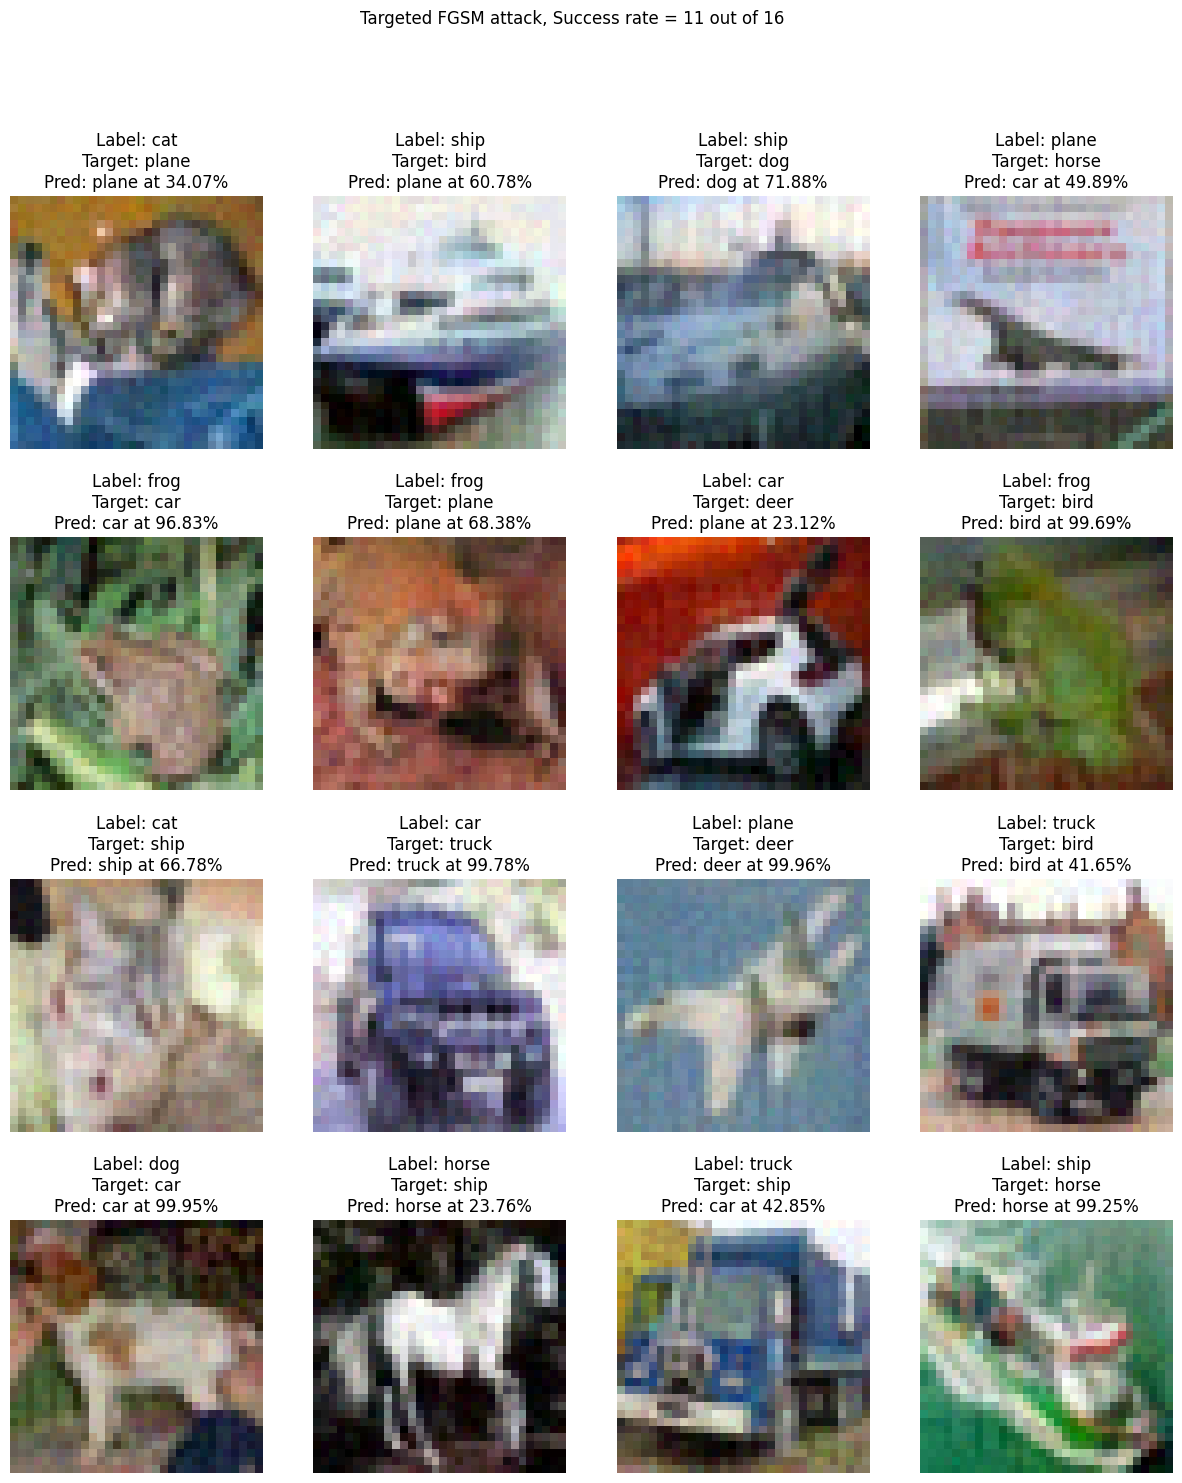

In [16]:
# we apply multiple FGSMs in this case
x_adv = x_test.to(device)
for _ in range(3):
    x_adv = FGSM_targeted(net, criterion, x_adv, y_target.to(device), eps=0.03)
score = net(x_adv).cpu()
x_adv = x_adv.cpu()
probability = F.softmax(score, dim=1)
predictions = torch.argmax(probability, dim=1)

fig, ax = plt.subplots(4, 4, figsize=(15,17))

for i in range(4):
    for j in range(4):
        index = 4*i+j
        image = np.clip((x_adv[index].permute(1,2,0).numpy()+1)/2, 0, 1)
        true = y_test[index]
        target = y_target[index]
        pred = predictions[index]
        prob = probability[index, pred].item()
        ax[i,j].set_title(f"Label: {classes[true]}\nTarget: {classes[target]}\nPred: {classes[pred]} at {round(prob*100,2)}%")
        ax[i,j].axis('off')
        ax[i,j].imshow(image)
    fig.suptitle(f"Targeted FGSM attack, Success rate = {torch.sum(predictions[0:16]==y_target[0:16])} out of {16}")
plt.show()

# Carlini Wagner Attack

The Carilini Wagner attack follows the regularized optimization
$$
\begin{aligned}
\min_{\mathbf{w}} \quad & \ell(\mathbf{w})\text{ (our objective function)}\\
\mathrm{when} \quad & \ell(\mathbf{w}) = \|\tanh(\mathbf{w}) - \mathbf{x_0}\| + \lambda(f(\tanh(\mathbf{w}),t))\\
\mathrm{and} \quad & f(\mathbf{x},t)=\max(\max_{i\neq t}\{g_i(\mathbf{x}+\mathbf{r})\}-g_t(\mathbf{x}+\mathbf{r}), -\kappa)
\end{aligned}
$$
since our data is scaled from -1 to 1 instead of 0 to 1, $\tanh(\mathbf{w})$ is scaled differently to compensate for that.

In [17]:
net = Net().to(device)
net.load_state_dict(torch.load("weights.pt", map_location=device))

<All keys matched successfully>

## $L_2$ attack

We carry gradient descent to optimize the loss term established above.

In [18]:
def carlini_wagner_l2(net, x, y_target, lambd=10, eps=0.01, iterations=100, mask=None):
    '''
    Parameters
        net : a neural network
        x : input tensor
        y_target : target classes
        lambd : regularization constant
        eps : maximum distance for initialized sample
        iterations : max number of iterations to terminate
        mask : pixels to ignore (never change), used for L0 case (1 for pixels to include)
    Return
        Adversarial examples
    '''
    x = torch.clone(x)
    if mask is None:
        mask = torch.ones_like(x)
    r = torch.rand_like(x)*eps*mask
    w = torch.arctanh(torch.clamp(x+r, -1, 1)).detach()
    w.requires_grad = True
    optimizer = torch.optim.Adam([w], lr=0.001)
    y_oh = F.one_hot(y_target, num_classes=10)

    for _ in tqdm(range(iterations)):
        net.zero_grad()
        optimizer.zero_grad()
        r = torch.tanh(w)-x
        x_adv = (x+r)*mask + (x)*(1-mask)
        score = net(x_adv)
        target_score = (score * y_oh).sum(-1)
        other_score = (score * (1-y_oh)).max(-1)[0]
        norm_dist = torch.sqrt(torch.sum(r.reshape(len(x), -1)**2, -1))
        reg = norm_dist + lambd*(-target_score+other_score)
        reg.sum().backward()
        optimizer.step()
        
        if torch.all(torch.argmax(score, dim=1) == y_target):
            # attack successful
            break
    return (torch.tanh(w))*mask + (x)*(1-mask)

100%|██████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 146.35it/s]


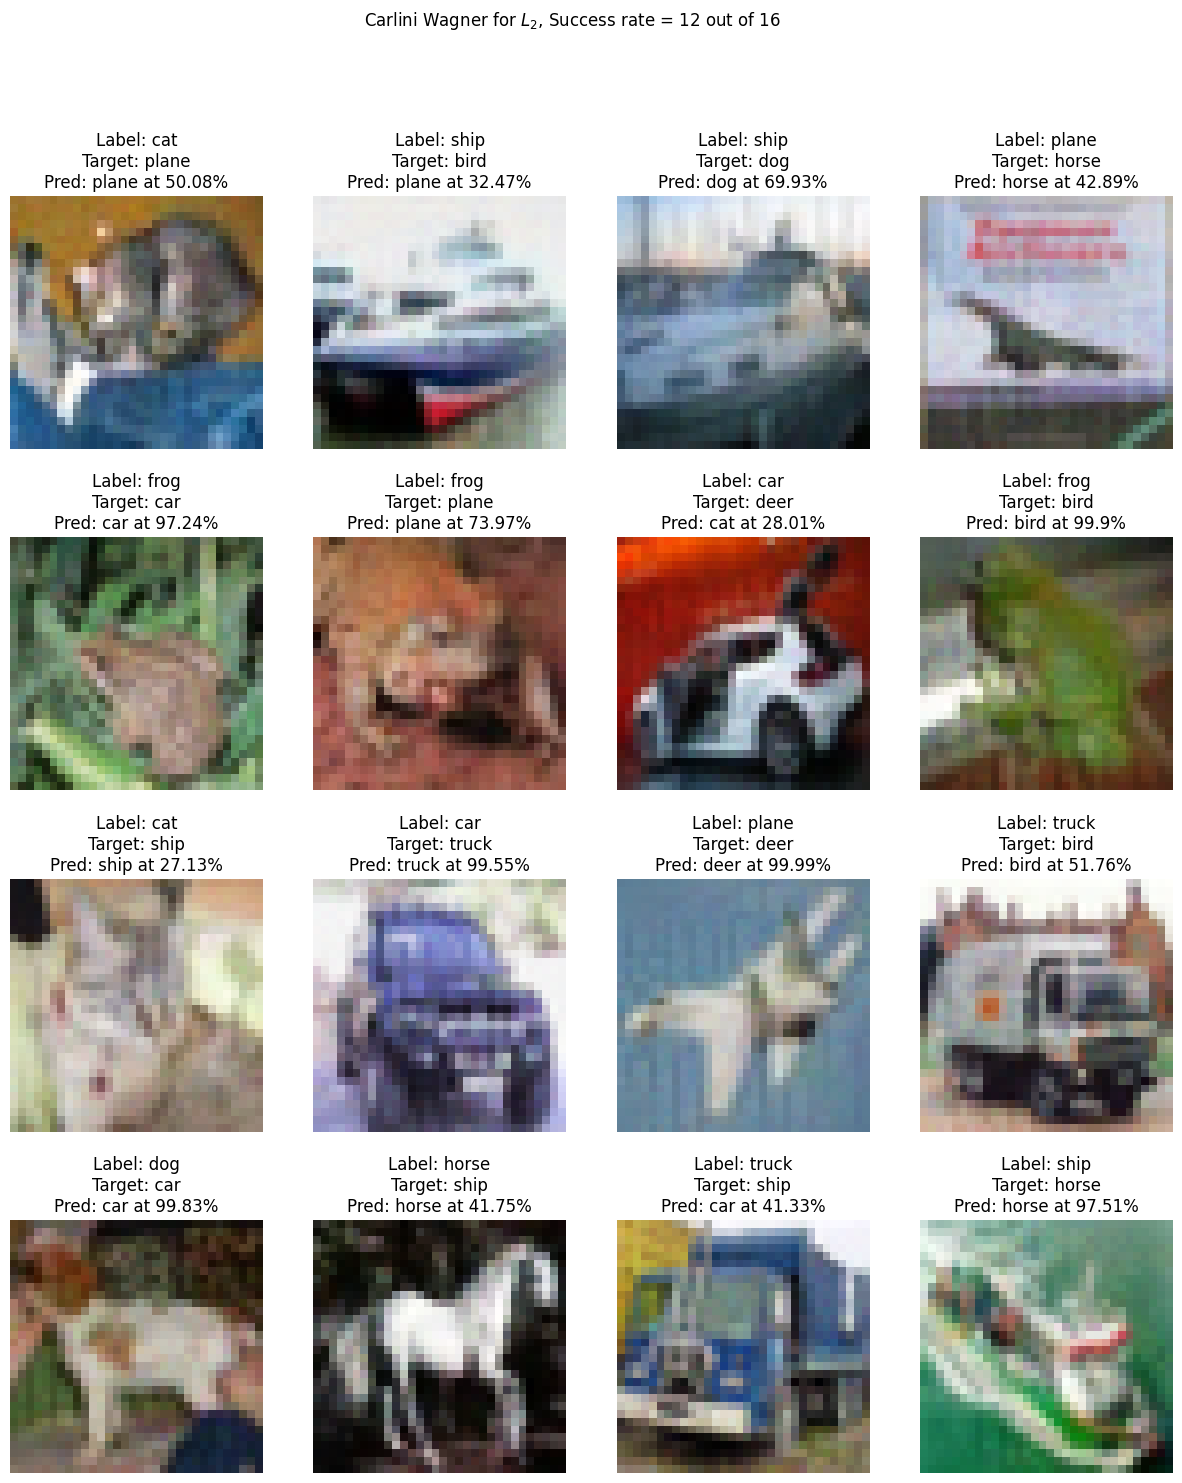

In [19]:
x_adv = carlini_wagner_l2(net, x_test.to(device), y_target.to(device), lambd=10, eps=1e-2, iterations=100)
score = net(x_adv).cpu().detach()
x_adv = x_adv.cpu().detach()
probability = F.softmax(score, dim=1)
predictions = torch.argmax(probability, dim=1)

fig, ax = plt.subplots(4, 4, figsize=(15,17))

for i in range(4):
    for j in range(4):
        index = 4*i+j
        image = np.clip((x_adv[index].permute(1,2,0).numpy()+1)/2, 0, 1)
        true = y_test[index]
        target = y_target[index]
        pred = predictions[index]
        prob = probability[index, pred].item()
        ax[i,j].set_title(f"Label: {classes[true]}\nTarget: {classes[target]}\nPred: {classes[pred]} at {round(prob*100,2)}%")
        ax[i,j].axis('off')
        ax[i,j].imshow(image)
    fig.suptitle(f"Carlini Wagner for $L_2$, Success rate = {torch.sum(predictions[0:16]==y_target[0:16])} out of {16}")
plt.show()

## $L_\infty$ attack

We optimize

$$
\begin{aligned}
\min_{\mathbf{r}} \quad & \ell_\tau(\mathbf{r})\text{ (our objective function defined on }\tau)\\
\mathrm{when} \quad & \ell(\mathbf{r}) = \sum_{i=1}^d\max(\mathbf{r}_i-\boldsymbol{\tau},0) + \lambda(f(\mathbf{x_0+r},t))\\
\mathrm{and} \quad & f(\mathbf{x},t)=\max(\max_{i\neq t}\{g_i(\mathbf{x}+\mathbf{r})\}-g_t(\mathbf{x}+\mathbf{r}), -\kappa)
\end{aligned}
$$

where we may then apply the change of variable to optimize $\mathbf{w}$ instead of $\mathbf{r}$. This formulation penalizes all terms in $\mathbf{r}$ exceeding $\tau$, describing a more sparse form of the $L_\infty$ norm (which only penalizes the greatest term). We begin optimizing $\ell_\tau(\mathbf{r})$ with $\tau=2$ (since our data is scaled from -1 to 1). If $\mathbf{r}_i<\tau$ for all $i=1,2,...d$ (which means $\tau$ can be optimized to a tighter bound), reduce $\tau$ by a factor of 0.9 and repeat the optimization of $\ell_\tau(\mathbf{r})$. 

In [20]:
def carlini_wagner_linfty(net, x, y_target, tau=2, lambd=10, eps=0.01, iterations=100):
    '''
    Parameters
        net : a neural network
        x : input tensor
        y_target : target classes
        lambd : regularization constant
        eps : maximum distance for initialized sample
        iterations : max number of iterations to terminate
    Return
        Adversarial examples
    '''
    while True:
        x = torch.clone(x)
        r = torch.rand_like(x)*eps
        w = torch.arctanh(torch.clamp(x+r, -1, 1)).detach()
        w.requires_grad = True
        optimizer = torch.optim.Adam([w], lr=0.001)
        y_oh = F.one_hot(y_target, num_classes=10)

        for _ in tqdm(range(iterations), desc=f"optizing at tau={round(tau, 4)}"):
            net.zero_grad()
            optimizer.zero_grad()
            r = torch.tanh(w)-x
            score = net(x+r)
            target_score = (score * y_oh).sum(-1)
            other_score = (score * (1-y_oh)).max(-1)[0]
            norm_dist = torch.clamp(torch.abs(r-tau),min=0).reshape(len(x), -1).sum(-1)
            reg = norm_dist + lambd*(-target_score+other_score)
            reg.sum().backward()
            optimizer.step()

            if torch.all(torch.argmax(score, dim=1) == y_target):
                # attack successful
                break
        r = torch.tanh(w)-x
        if torch.all(r.cpu()<tau):
            tau = tau*0.9
        else:
            break
    return torch.tanh(w)

optizing at tau=0.1292: 100%|██████████████████████████████████████████████████| 100/100 [00:00<00:00, 193.75it/s]


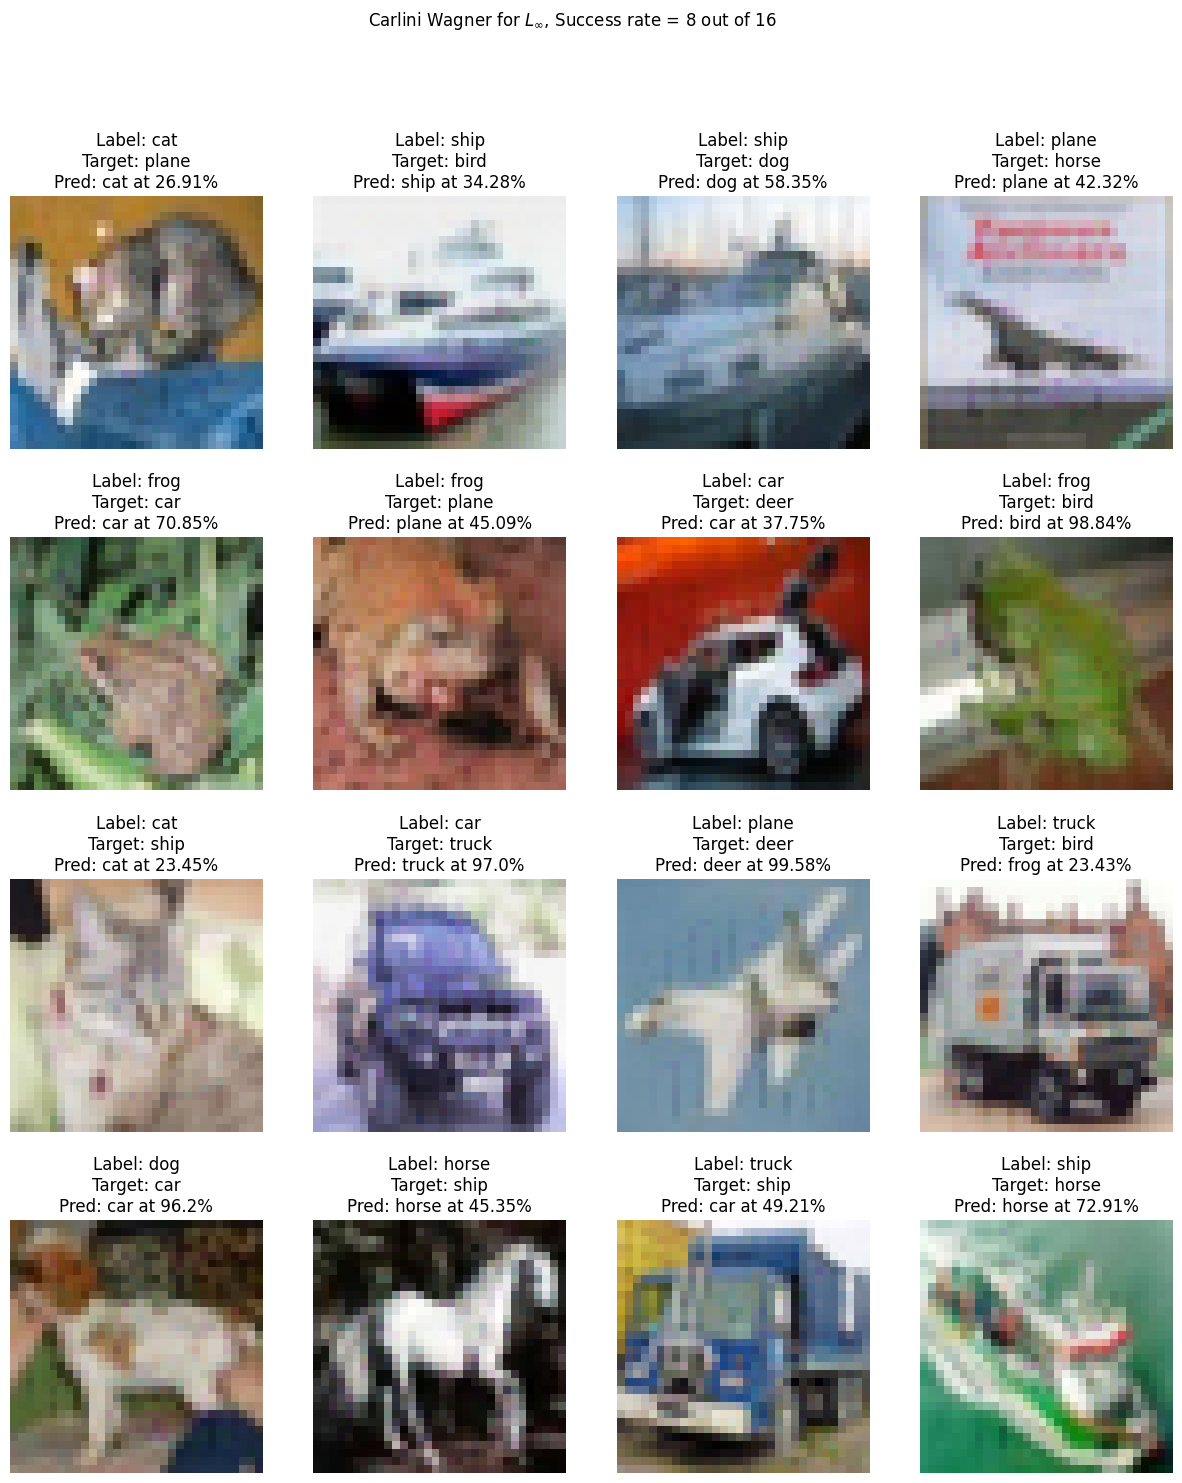

In [21]:
x_adv = carlini_wagner_linfty(net, x_test.to(device), y_target.to(device), lambd=10, eps=1e-2, iterations=100)
score = net(x_adv).cpu().detach()
x_adv = x_adv.cpu().detach()
probability = F.softmax(score, dim=1)
predictions = torch.argmax(probability, dim=1)

fig, ax = plt.subplots(4, 4, figsize=(15,17))

for i in range(4):
    for j in range(4):
        index = 4*i+j
        image = np.clip((x_adv[index].permute(1,2,0).numpy()+1)/2, 0, 1)
        true = y_test[index]
        target = y_target[index]
        pred = predictions[index]
        prob = probability[index, pred].item()
        ax[i,j].set_title(f"Label: {classes[true]}\nTarget: {classes[target]}\nPred: {classes[pred]} at {round(prob*100,2)}%")
        ax[i,j].axis('off')
        ax[i,j].imshow(image)
    fig.suptitle(f"Carlini Wagner for $L_\infty$, Success rate = {torch.sum(predictions[0:16]==y_target[0:16])} out of {16}")
plt.show()

# $L_0$ attack

This metric is non-differentiable, and is such incompatible with gradient descent. As we only want to determine the entries of $\mathbf{x_0}$ to change (while not caring about the magnitude of change), we employ the solution from $L_2$ norm to aid our search. 
    
Define $\mathcal{P}\subseteq\{1,2,\dots,d\}$ as the set of allowed pixel/entries to be perturbed (this means if $i\notin\mathcal{P}$, we automatically fix $\mathbf{r}_i=0$). Initialize $\mathcal{P}=\{1,2,\dots,d\}$, we find the perturbation $\mathbf{r}_\mathcal{P}$ returned from the $L_2$ norm. Define $\mathbf{h}=\nabla f(\mathbf{x_0+r_\mathcal{P}},t)$. We may select the entry/pixel $i=\arg\min_i \mathbf{h}_i{\mathbf{r}_\mathcal{P}}_i$. The authors presented that $\mathbf{h}_i{\mathbf{r}_\mathcal{P}}_i$ intuitively tells us the amount of reduction in $f$ we obtain from the perturbation $\mathbf{x_0+r_\mathcal{P}}$; $\mathbf{h}_i$ is the reduction in $f$ per change, and ${\mathbf{r}_\mathcal{P}}_i$ is the change. The $i^\text{th}$ entry, causing the least amount of change, is thus removed from $\mathcal{P}$. We repeat this process until $\mathbf{r}_\mathcal{P}$ could not be found.

Since removing pixels one by one is slow for, we instead remove all points where $\mathbf{h}_i{\mathbf{r}_\mathcal{P}}_i<0$ as it signified how changing those points work against our objective.

In [22]:
def carlini_wagner_l0(net, x, y_target, lambd=10, eps=0.01, iterations=100):
    '''
    Parameters
        net : a neural network
        x : input tensor
        y_target : target classes
        lambd : regularization constant
        eps : maximum distance for initialized sample
        iterations : max number of iterations to terminate
    Return
        Adversarial examples
    '''
    mask = torch.ones_like(x)
    best_score = None
    while True:
        x_adv = carlini_wagner_l2(net, x, y_target, lambd=lambd, eps=eps, iterations=iterations, mask=mask)
        y_oh = F.one_hot(y_target.to(device), num_classes=10)
        r = torch.clone(x_adv-x)
        r.reqire_grad = True
        r.retain_grad()
        net.zero_grad()
        score = net(x_test.to(device)+r)
        target_score = (score * y_oh).sum(-1)
        other_score = (score * (1-y_oh)).max(-1)[0]
        f = other_score - target_score
        f.sum().backward()
        h = r.grad 
        if best_score is None:
            best_score = torch.sum(f<0).item()
            mask *= ((h*r)>=0).float()
        else:
            # attack not found
            if torch.sum(f<0).item() < best_score:
                break
            else:
                mask *= ((h*r)>=0).float()
    return carlini_wagner_l2(net, x, y_target, lambd=lambd, eps=eps, iterations=iterations, mask=mask), mask

100%|██████████████████████████████████████████████████████████████████████████| 500/500 [00:02<00:00, 211.91it/s]


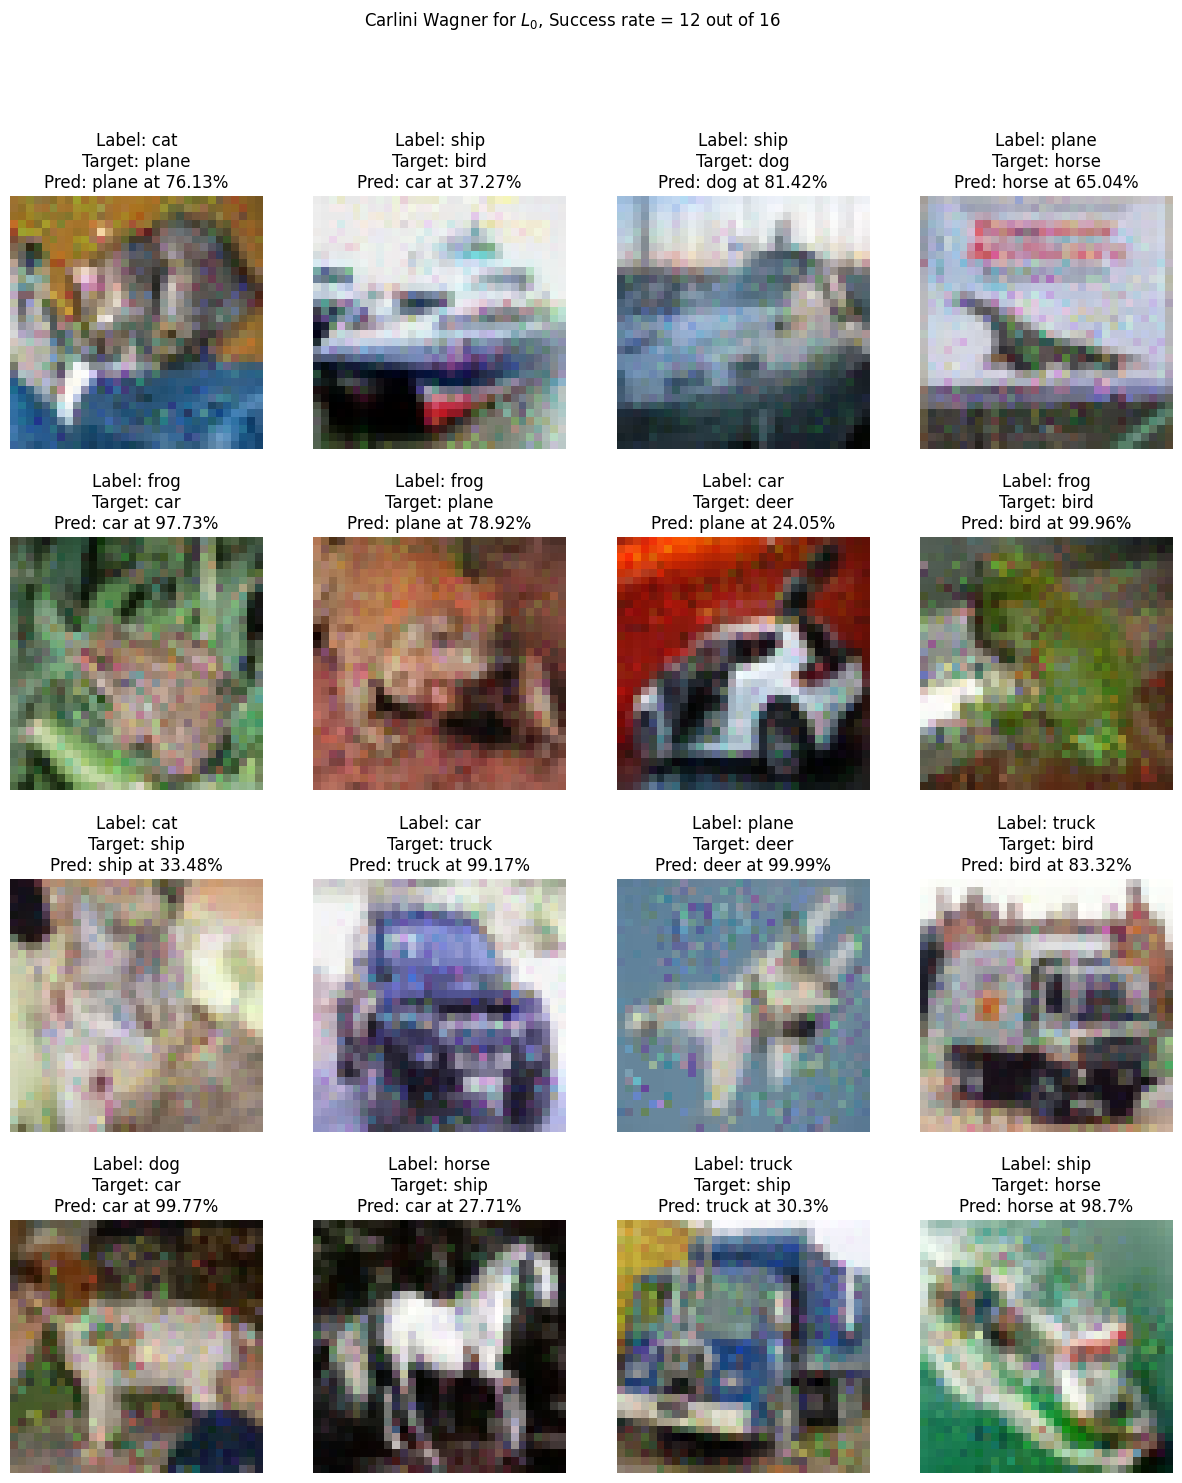

In [23]:
x_adv, mask = carlini_wagner_l0(net, x_test.to(device), y_target.to(device), lambd=10, eps=1e-2, iterations=500)
score = net(x_adv).cpu().detach()
x_adv = x_adv.cpu().detach()
probability = F.softmax(score, dim=1)
predictions = torch.argmax(probability, dim=1)

fig, ax = plt.subplots(4, 4, figsize=(15,17))

for i in range(4):
    for j in range(4):
        index = 4*i+j
        image = np.clip((x_adv[index].permute(1,2,0).numpy()+1)/2, 0, 1)
        true = y_test[index]
        target = y_target[index]
        pred = predictions[index]
        prob = probability[index, pred].item()
        ax[i,j].set_title(f"Label: {classes[true]}\nTarget: {classes[target]}\nPred: {classes[pred]} at {round(prob*100,2)}%")
        ax[i,j].axis('off')
        ax[i,j].imshow(image)
    fig.suptitle(f"Carlini Wagner for $L_0$, Success rate = {torch.sum(predictions[0:16]==y_target[0:16])} out of {16}")
plt.show()